In [2]:
from __future__ import division, print_function

import sys
import matplotlib
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
sys.path.append('../')
sys.path.append('../external/caffe-natural-language-object-retrieval/python/')
sys.path.append('../external/caffe-natural-language-object-retrieval/examples/coco_caption/')
import caffe

import util
from captioner import Captioner
import retriever

In [3]:
im_file = './demo_data/40429.jpg'
edgebox_file = './demo_data/40429.txt'  # pre-extracted EdgeBox proposals
query = 'pillar building in the middle'

pretrained_weights_path = '../models/scrc_full_vgg.caffemodel'
gpu_id = 0  # the GPU to test the SCRC model

In [4]:
# Initialize the retrieval model
image_net_proto = '../prototxt/VGG_ILSVRC_16_layers_deploy.prototxt'
lstm_net_proto = '../prototxt/scrc_word_to_preds_full.prototxt'
vocab_file = '../data/vocabulary.txt'
# utilize the captioner module from LRCN
captioner = Captioner(pretrained_weights_path, image_net_proto, lstm_net_proto,
                      vocab_file, gpu_id)
captioner.set_image_batch_size(50)  # decrease the number if your GPU memory is small
vocab_dict = retriever.build_vocab_dict_from_captioner(captioner)

In [5]:
im = skimage.io.imread(im_file)
imsize = np.array([im.shape[1], im.shape[0]])  # [width, height]
candidate_boxes = np.loadtxt(edgebox_file).astype(int)

In [6]:
# Compute features
region_feature = retriever.compute_descriptors_edgebox(captioner, im,
                                                    candidate_boxes)
spatial_feature = retriever.compute_spatial_feat(candidate_boxes, imsize)
descriptors = np.concatenate((region_feature, spatial_feature), axis=1)
context_feature = captioner.compute_descriptors([im], output_name='fc7')

# Compute scores of each candidate region
scores = retriever.score_descriptors_context(descriptors, query,
                                             context_feature, captioner,
                                             vocab_dict)

# Retrieve the top-scoring candidate region given the query
retrieved_bbox = candidate_boxes[np.argmax(scores)]

Computing descriptors for images 0-0 of 1


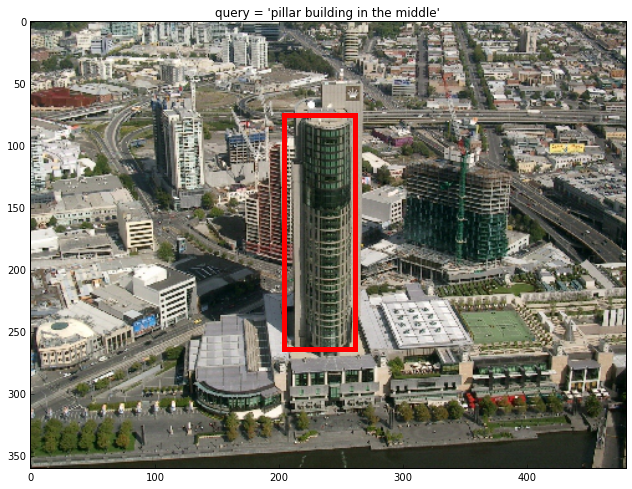

In [7]:
# Visualize the retrieval result
plt.figure(figsize=(12, 8))
plt.imshow(im)
ax = plt.gca()
x_min, y_min, x_max, y_max = retrieved_bbox
ax.add_patch(mpatches.Rectangle((x_min, y_min), x_max-x_min+1, y_max-y_min+1,
                                fill=False, edgecolor='r', linewidth=5))
_ = plt.title("query = '%s'" % query)